In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os

In [65]:
! rm -r /content/checkpoint/
! rm -r /content/run/

# Functions

In [66]:
# Função para separar um tensorflow dataset em treino, validação e teste
def ds_split(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    ds_size = dataset.cardinality().numpy()
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train = ds.take(train_size)    
    val = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)
    
    return train, val, test

In [67]:
# Utiliza a função ds_split para separar um dataset.
# Cria batches em todos os datasets gerados.
def mini_batch(ds, batch_size=10):
    train, val, test = ds_split(ds, 0.8, 0.1, 0.1)
    train = train.shuffle(train.cardinality().numpy(), seed=123).batch(batch_size)
    val = val.batch(batch_size)
    test = test.batch(batch_size)
    return train, val, test

In [68]:
# Esta classe treina multiplos modelos, variando o número de unidades da camada oculta
# e a taxa de aprendizado. Utiliza a variável 'current' para identificar qual o modelo
# sendo treinado atualmente. 
class Model:
    def __init__(self, patience=10, epochs=200):
        self.current = 1
        self.val_loss = []
        self.test_loss = []
        self.train_loss = []
        self.patience = patience
        self.epochs = epochs
        self.units = [25, 50, 100]
        self.rates = [0.5, 1, 10]
        for dir in ['checkpoint', 'run']:
            if not os.path.exists(dir):
                os.makedirs(dir)
        

    def units_rate(self, train, validation, test):
        for i in range(9):
            units = self.units[i // 3]
            rate = self.rates[i % 3]
            # Cria um novo modelo com 'units' unidades na camada oculta
            model = Sequential([
                Flatten(input_shape=(28, 28)),
                Dense(units, activation='sigmoid'),
                Dense(10)])
        
            # filepath dos checkpoints de modelos treinados
            fp = (
                f"./checkpoint/{self.current}-epoch{{epoch:3d}}-"
                "train{loss:.3f}-val{val_loss:.3f}.hdf5"
            )
            # Checkpoint utilizado para salvar o melhor
            # modelo para o conjunto de parãmetros atual
            checkpoint = ModelCheckpoint(filepath=fp, monitor='val_loss', 
                                            save_best_only=True, mode='min')
            
            early_stopping = EarlyStopping(monitor="val_loss",
                                            patience=self.patience,
                                            restore_best_weights=True,
                                            mode='min')
            
            csv_logger = CSVLogger(f'./run/{self.current}.csv')
            # Compila o modelo
            model.compile(optimizer=SGD(learning_rate=rate), 
                            loss=SparseCategoricalCrossentropy(from_logits=True))
            
            # Treinamento do modelo
            metrics = model.fit(train, validation_data=validation, epochs=self.epochs, verbose=0, 
                                callbacks=[checkpoint, csv_logger, early_stopping])
            
            # Teste do modelo
            score = model.evaluate(test, return_dict=True)

            self.test_loss.append(score['loss'])
            self.train_loss.append(metrics.history['loss'])
            self.val_loss.append(metrics.history['val_loss'])
            self.current += 1
                

In [69]:
# Função para plot dos erros
def plot_models(title, train, validation, test):
    fig, ax = plt.subplots(3, 3, figsize=(14, 9), constrained_layout=True)
    fig.suptitle(title, fontsize=16)
    for i in range(9):
        ax[i // 3, i % 3].plot(train[i], label='Train')
        ax[i // 3, i % 3].plot(validation[i], label='Validation')
        ax[i // 3, i % 3].plot([0, len(train[i])], [test[i], test[i]] , label=f'Test: {test[i]:.2f}')
        ax[i // 3, i % 3].set_title(f'HL Units: {model.units[i // 3]}, Rate: {model.rates[i % 3]}')
        if i == 3: ax[1, 0].set_ylabel('Crossentropy', fontsize=16)
        ax[i // 3, i % 3].legend(loc=7)

# Dataset

In [ ]:
!wget --quiet https://raw.githubusercontent.com/joaopmo/ml-ufmg/main/data_tp1

In [ ]:
file_path = str(Path("data_tp1").resolve())

In [ ]:
data = np.genfromtxt(file_path, delimiter=",", dtype=np.uint8)

In [ ]:
labels, images = data[:, :1], data[:, 1:]
labels = labels.reshape(5000)
images = images.reshape(5000, 28, 28)

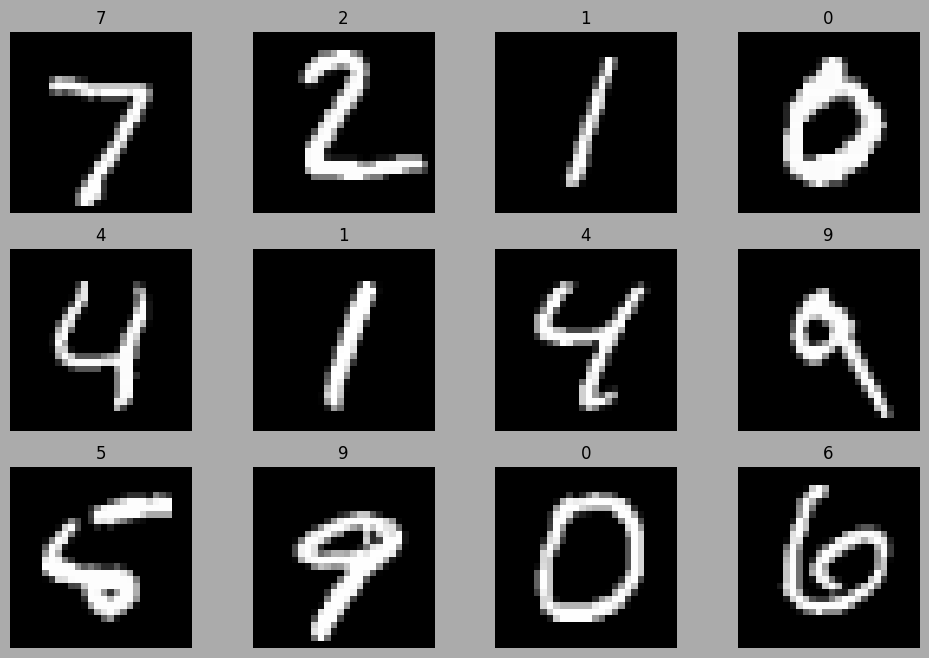

In [70]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
fig.patch.set_facecolor('#ababab')
for i in range(12):
    img = images[i]
    label = labels[i]
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

# Modelos

In [71]:
model = Model(patience=50, epochs=200)

## 01 - 09

* Taxa de Aprendizado: 0.5, 1, 10
* Unidades na Camada Oculta: 25, 50, 100
* Algoritmo de Cálculo do Gradiente: Gradient Descent

In [72]:
train, validation, test = mini_batch(dataset, batch_size=4000)
model.units_rate(train, validation, test)

1/1 [==============================] - 0s 18ms/step - loss: 17.6778


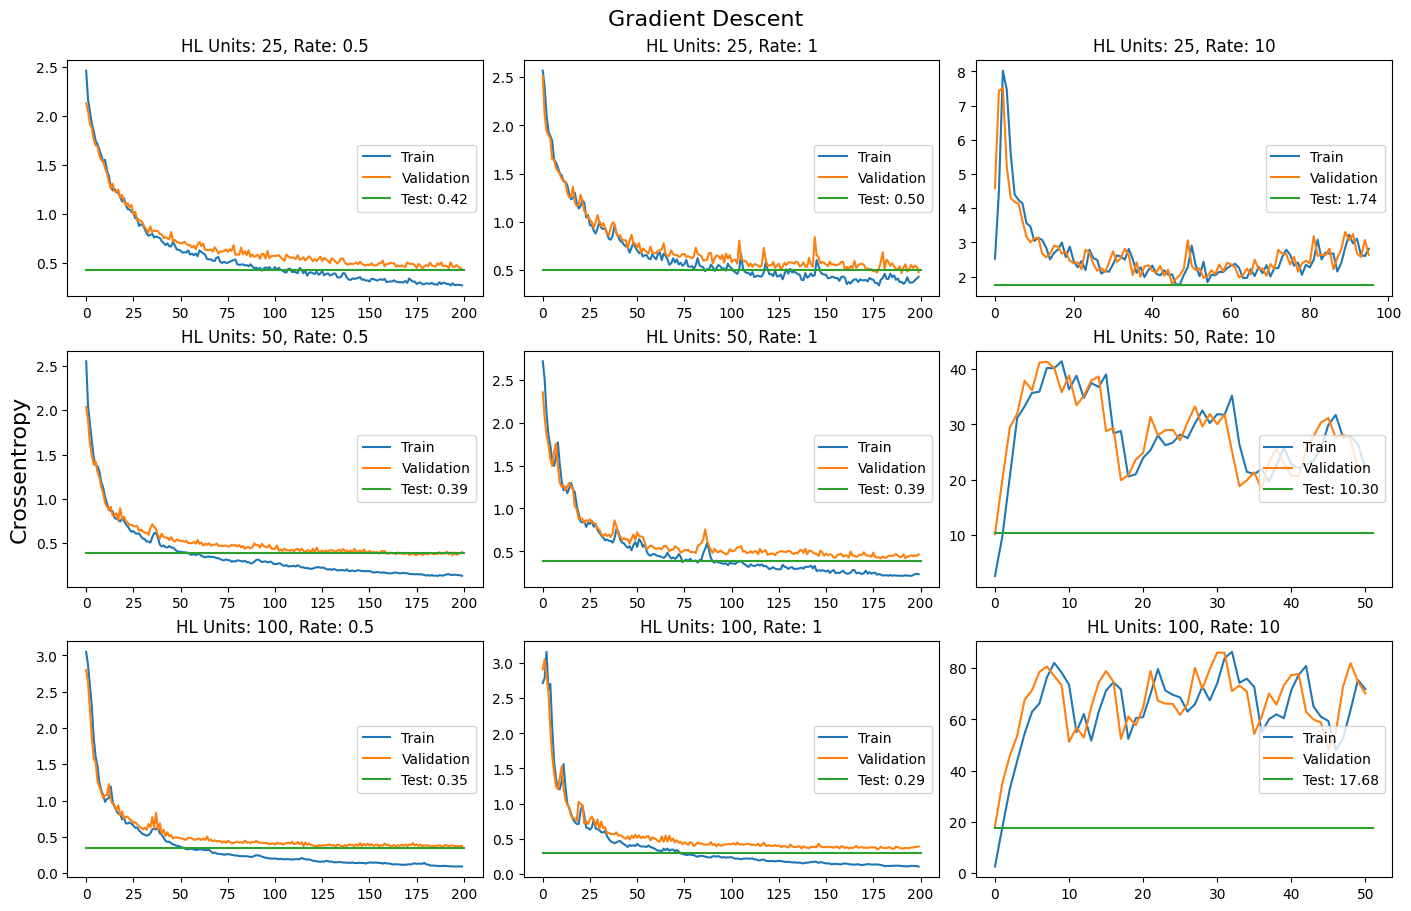

In [73]:
plot_models('Gradient Descent', model.train_loss[:9], model.val_loss[:9], model.test_loss[:9])

## 10 - 18

* Taxa de Aprendizado: 0.5, 1, 10
* Unidades na Camada Oculta: 25, 50, 100
* Algoritmo de Cálculo do Gradiente: Stochastic Gradient Descent

In [ ]:
train, validation, test = mini_batch(dataset, batch_size=1)
model.units_rate(train, validation, test)

  1/500 [..............................] - ETA: 4s - loss: 13.5295

In [ ]:
plot_models('Stochastic Gradient Descent', model.train_loss[9:18], model.val_loss[9:18], model.test_loss[9:18])

## 19 - 27

* Taxa de Aprendizado: 0.5, 1, 10
* Unidades na Camada Oculta: 25, 50, 100
* Algoritmo de Cálculo do Gradiente: Mini Batch 10

In [ ]:
train, validation, test = mini_batch(dataset, batch_size=10)
model.units_rate(train, validation, test)

In [ ]:
plot_models('Mini Batch 10', model.train_loss[18:27], model.val_loss[18:27], model.test_loss[18:27])

## 28 - 36

* Taxa de Aprendizado: 0.5, 1, 10
* Unidades na Camada Oculta: 25, 50, 100
* Algoritmo de Cálculo do Gradiente: Mini Batch 50

In [ ]:
train, validation, test = mini_batch(dataset, batch_size=50)
model.units_rate(train, validation, test)

In [ ]:
plot_models('Mini Batch 50', model.train_loss[27:36], model.val_loss[18:36], model.test_loss[18:36])

In [ ]:
with open(str(Path("metrics.txt").resolve()), 'w') as fp:
    for metric in model.history:
        fp.write(','.join(map(str, metric)) + '\n')